## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.
As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [2]:
import pandas as pd
import numpy as np
# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

/tmp/ipykernel_28014/3356708783.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


In [3]:
print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [4]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [5]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [6]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs
Date                                                                        
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208


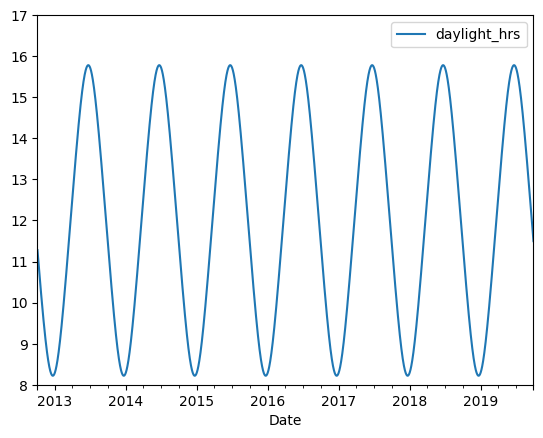

In [7]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp('2000-12-21')).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [8]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [9]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [10]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

Lasso Best Alpha: {'alpha': 0.11513953993264481}
Laso CV score: 233792.1271999313
Ridge Best Alpha: {'alpha': 0.5963623316594643}
Rdige CV score: 233739.05385091278
Linear Regression CV Score (MSE): 233807.34994833203
Lasso Test Score (R²): 0.8803840481176711
Ridge Test Score (R²): 0.8799326304260703
Linear Regression Test Score (R²): 0.8804570314760505
Best Model: Ridge(alpha=0.5963623316594643, tol=0.01)


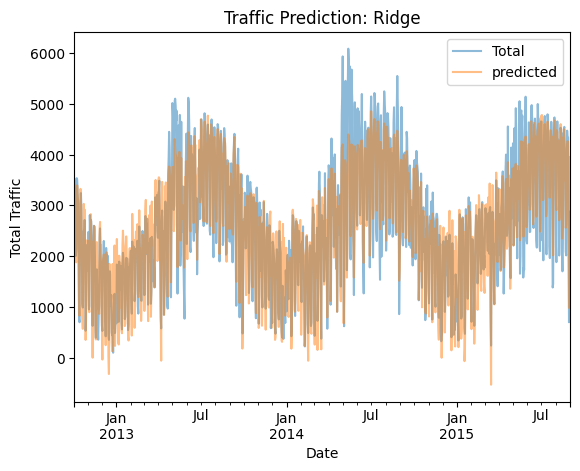

In [15]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize the models
linear_model = LinearRegression(fit_intercept=False)

lasso_model = Lasso(tol=.01)
ridge_model = Ridge(tol=.01)

lasso_param_grid = {'alpha': np.logspace(-4, 1, 50)}
ridge_param_grid = {'alpha': np.logspace(-4, 1, 50)}

# setup lasso with RandomizedSearchCV
lasso_search = RandomizedSearchCV(lasso_model, lasso_param_grid, n_iter=50, 
                                  scoring='neg_mean_squared_error', cv=10, random_state=42)
lasso_search.fit(X_train, y_train)

#s setup ridge with RandomizedSearchCV
ridge_search = RandomizedSearchCV(ridge_model, ridge_param_grid, n_iter=50,
                                 scoring='neg_mean_squared_error', cv=10, random_state=42)
ridge_search.fit(X_train, y_train)

#find best
lasso_best = lasso_search.best_estimator_
ridge_best = ridge_search.best_estimator_

#find cv score average
lasso_cv_score = cross_val_score(lasso_best, X, y, cv=10, scoring='neg_mean_squared_error').mean()
ridge_cv_score = cross_val_score(ridge_best, X, y, cv=10, scoring='neg_mean_squared_error').mean()

print("Lasso Best Alpha:", lasso_search.best_params_)
print("Laso CV score:", -lasso_cv_score)

print("Ridge Best Alpha:", ridge_search.best_params_)
print("Rdige CV score:", -ridge_cv_score)

# do LinearRegression and find Cross val. score
linear_model.fit(X_train, y_train)
linear_cv_score = cross_val_score(linear_model, X, y, cv=10, scoring='neg_mean_squared_error').mean()
print("Linear Regression CV Score (MSE):", -linear_cv_score)

for model_name, model in [('Lasso', lasso_best), ('Ridge', ridge_best), ('Linear Regression', linear_model)]:
    test_score = model.score(X_test, y_test)
    print(f"{model_name} Test Score (R²):", test_score)

# Plot predicted vs actual for the best model
best_model = lasso_best if -lasso_cv_score < -ridge_cv_score else ridge_best
print("Best Model:", best_model)
daily['predicted'] = best_model.predict(X)
daily[['Total', 'predicted']].plot(alpha=0.5)
plt.title(f"Traffic Prediction: {best_model.__class__.__name__}")
plt.xlabel("Date")
plt.ylabel("Total Traffic")
plt.show()


Finally, we can compare the total and predicted bicycle traffic visually:

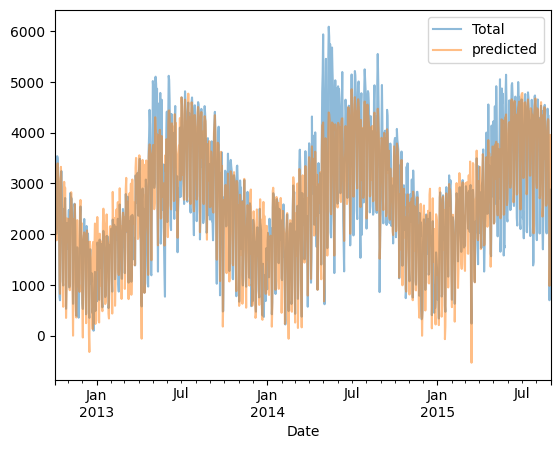

In [12]:
# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [13]:
# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params

Mon              538.158664
Tue              669.136338
Wed              580.431393
Thu              514.692487
Fri              227.883416
Sat            -1056.535794
Sun            -1085.950840
holiday        -1071.418473
daylight_hrs     127.496488
PRCP            -699.290917
dry day          536.501095
Temp (C)          64.152219
annual            26.031503
dtype: float64

This is not enough. Let's see the correlation matrix:

In [14]:
import matplotlib.pyplot as plt

daily[:5]
daily.corr(method='spearman')


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619643,-0.465832,0.620759,0.429007,0.235085,0.932782
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000398,-0.025984,0.019147,0.017129,0.002658,0.146320
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,0.006232,0.004420,-0.010122,0.003987,0.223253
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000582,0.005944,-0.011469,0.000779,-0.003987,0.178814
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000411,0.010861,-0.001675,-0.015572,-0.002658,0.140864
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000245,0.026654,0.000109,-0.037373,-0.001329,0.038755
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000039,-0.017684,-0.005938,0.028030,0.000000,-0.356806
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000227,-0.006022,-0.004595,0.017129,0.001329,-0.371200
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,-0.050033,-0.068670,0.059115,-0.027033,-0.116916
daylight_hrs,0.619643,0.000398,0.000651,-0.000582,-0.000411,-0.000245,-0.000039,0.000227,-0.078683,1.000000,-0.309827,0.790928,0.307485,0.251385,0.688241


Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
